# Recommender Systems 2022/23

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [2]:
import pandas as pd
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


### BUILD the SPARSE URM matrix

In [4]:
import scipy.sparse as sps
import numpy as np

mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


In [5]:
n_users = len(URM_all_dataframe["UserID"].unique())
n_items = len(URM_all_dataframe["ItemID"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Let's take a look at the URM


In [6]:
URM_all = sps.csr_matrix(URM_all)
items_per_user = np.ediff1d(URM_all.indptr)

URM_all = sps.csc_matrix(URM_all)
users_per_item = np.ediff1d(URM_all.indptr)

URM_all = sps.csr_matrix(URM_all)

In [7]:
print(items_per_user.shape)
print(users_per_item.shape)

(12638,)
(22222,)


In [8]:
items_per_user = np.sort(items_per_user)
users_per_item = np.sort(users_per_item)

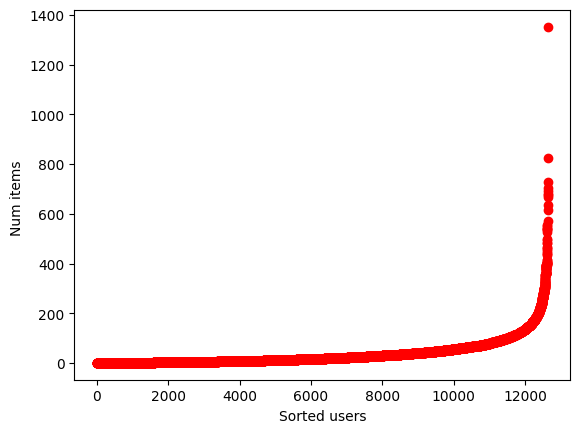

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(items_per_user, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted users')
pyplot.show()

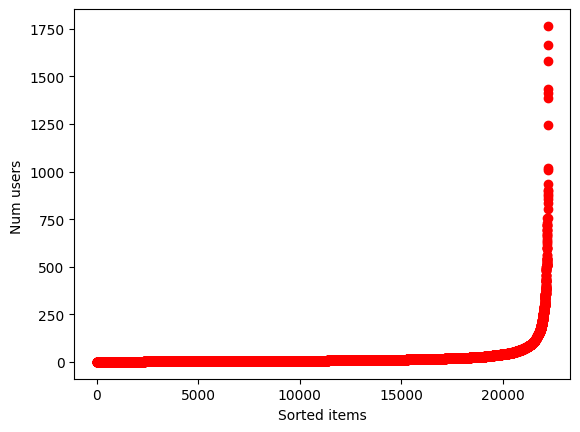

In [10]:
pyplot.plot(users_per_item, 'ro')
pyplot.ylabel('Num users ')
pyplot.xlabel('Sorted items')
pyplot.show()

## DATASET SPLIT

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2652 (21.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2181 (17.3%) Users that have less than 1 test interactions


## Similarity matrix

In [12]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 22222 (100.0%), 4937.61 column/sec. Elapsed time 4.50 sec


<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 2106142 stored elements in Compressed Sparse Row format>

### Prediction for a certain user

In [13]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

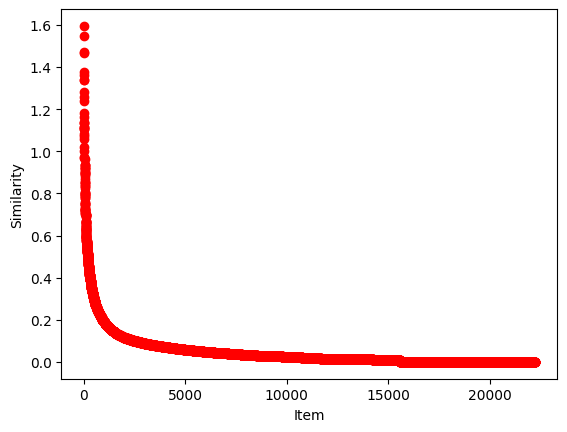

array([288, 452, 287, 189, 517, 284, 952, 228, 120, 290])

In [14]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()
ranking[0:10]

### All together inside a class

In [15]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=50.0, topK=10)

top_recommender = TopPop(URM_train)
top_recommender.fit()

ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5929.89 column/sec. Elapsed time 3.75 sec
TopPopRecommender: URM Detected 458 ( 3.6%) users with no interactions.
TopPopRecommender: URM Detected 332 ( 1.5%) items with no interactions.


In [16]:
evaluator_test.evaluateRecommender(top_recommender)

EvaluatorHoldout: Processed 10457 (100.0%) in 3.04 sec. Users per second: 3445


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.028593                 0.053046  0.045684  0.011367    0.020432   
 
             MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                       ...   
 10      0.09126  0.044273  0.035172  0.231424      0.101775  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.827425          0.191486    0.827425       0.000536   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            3.600794                   0.913076             0.001555   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

## Hyperparameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation qualtiy on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5882.79 column/sec. Elapsed time 3.78 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 1.80 sec. Users per second: 5559
ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5883.97 column/sec. Elapsed time 3.78 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 1.83 sec. Users per second: 5448
ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5314.04 column/sec. El

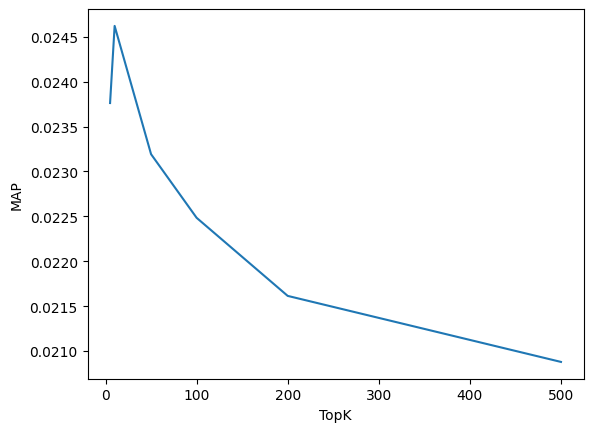

In [17]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [5, 10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5049.64 column/sec. Elapsed time 4.40 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 2.48 sec. Users per second: 4019
ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5069.52 column/sec. Elapsed time 4.38 sec
EvaluatorHoldout: Processed 9986 (100.0%) in 2.74 sec. Users per second: 3645
ItemKNNCFRecommender: URM Detected 458 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 5116.21 column/sec. El

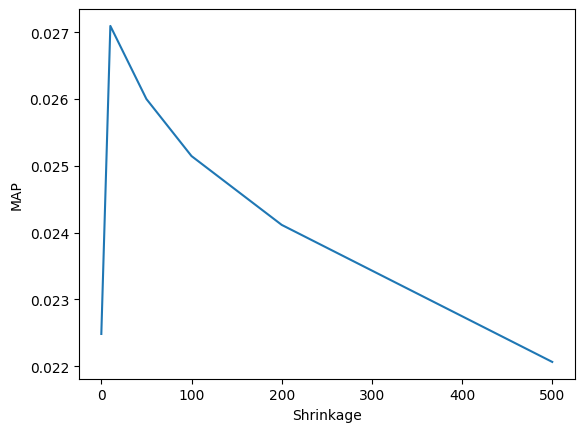

In [18]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

# Generate submissions

In [19]:
# RETRAIN WITH FULL DATASET
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
recommender = PureSVDRecommender(URM_all)
recommender.fit(num_factors=65)

top_recommender = TopPop(URM_all)
top_recommender.fit()

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.46 sec


In [20]:
top_recommender.recommend(np.array([22,2,5]), cutoff=10)

[[517, 189, 44, 0, 284, 808, 285, 557, 1, 1266],
 [517, 189, 44, 0, 284, 808, 285, 557, 1, 1266],
 [517, 0, 284, 808, 285, 557, 1, 1266, 1265, 841]]

In [21]:
import pandas as pd
URM_path = "data_target_users_test.csv"
URM_all_submission_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int},
                                engine='python')

URM_all_submission_dataframe.columns = ["UserID"]

In [22]:
URM_all_submission_dataframe["UserIDMapped"] = URM_all_submission_dataframe["UserID"].map(user_original_ID_to_index)

In [24]:
import pandas as pd
# Assuming you have a DataFrame URM_all_submission_dataframe with 'UserIDMapped' and 'item_list' columns

# First, create a mask for non-null 'UserIDMapped' values
mask = ~URM_all_submission_dataframe['UserIDMapped'].isna()
URM_all_submission_dataframe['item_list'] = top_recommender.recommend(URM_all_submission_dataframe['UserIDMapped'], cutoff=10, remove_seen_flag=False)
URM_all_submission_dataframe.loc[mask, 'item_list'] = pd.Series(recommender.recommend(URM_all_submission_dataframe.loc[mask, 'UserIDMapped'].to_numpy().astype(int), cutoff=10, remove_seen_flag=True), index=URM_all_submission_dataframe.index[mask])

In [25]:
item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)
URM_all_submission_dataframe['item_list'] = URM_all_submission_dataframe['item_list'].apply(lambda item_indices: [item_index_to_original_id[index] for index in item_indices])

In [26]:
submission = URM_all_submission_dataframe[["UserID","item_list"]]
submission.columns = ["user_id", "item_list"]
submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets

# Convert item_list to string format
submission['item_list'] = submission['item_list'].astype(str)

# Save to CSV without quotes and with the desired format
# submission.to_csv("submission.csv", index=False, header=["user_id", "item_list"], quoting=csv.QUOTE_NONE, sep=',')
def write_csv_without_quotes(df, file_path):
    with open(file_path, 'w', newline='') as f:
        f.write("user_id,item_list\n")
        for index, row in df.iterrows():
            f.write(f"{row['user_id']},{row['item_list']}\n")

# Save the DataFrame to CSV without quotes and with the desired format
write_csv_without_quotes(submission, "submission.csv")

/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_50253/2149847291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets
/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_50253/2149847291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].astype(str)


In [141]:
submission['item_list']

0            36 101 52 102 112 139 403 79 146 257
1               47 50 12 125 28 46 121 69 102 131
2             59 259 414 536 584 648 117 956 12 5
3                28 50 145 249 136 97 75 46 61 54
4           116 77 179 131 78 164 135 243 148 401
                           ...                   
10877       161 155 108 33 90 337 506 105 354 403
10878     13 133 57 6179 593 474 6720 207 579 350
10879    102 49 809 1446 1411 205 147 1674 11 133
10880           23 129 32 82 242 313 89 96 19 282
10881      347 292 329 24 353 112 139 408 415 686
Name: item_list, Length: 10882, dtype: object